In [1]:
import os
import pickle
import sys

import numpy as np
import torch
import torch.utils.data
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class CIFAR10ImageDataSet(torch.utils.data.Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, index):
        img = self.data[index]

        img_original = transforms.functional.to_pil_image(torch.from_numpy(img.astype(np.uint8)))

        if self.transforms is not None:
            img_original = self.transforms(img_original)

        img_original = np.asarray(img_original)

        img_original = img_original / 255

        img_lab = rgb2lab(img_original)
        img_lab = (img_lab + 128) / 255

        img_ab = img_lab[:, :, 1:3]
        img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()

        img_gray = rgb2gray(img_original)
        img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()

        return img_gray, img_ab, img_original

    def __len__(self):
        return self.data.shape[0]

In [3]:
def unpickle_cifar10(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b"data"]


def get_cifar10_loaders(dataset_path, batch_size):
    """
    Get CIFAR-10 data set loaders
    """

    '''
    Process training data into a DataLoader object
    '''
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip()
    ])

    train_set = datasets.CIFAR10(root=dataset_path, train=True, download=True)
    num_training_points = train_set.__len__()
    num_points_training_batch = int(num_training_points / batch_size)

    train_data = np.array([]).reshape(0, 3, 32, 32)

    data_batch_name = 'cifar-10-batches-py/data_batch_{}'
    for batch_num in range(1, 6):
        data_batch = data_batch_name.format(batch_num)
        batch_dir = os.path.join(dataset_path, data_batch)
        train_data = np.append(train_data, np.reshape(unpickle_cifar10(batch_dir),
                                                      (num_points_training_batch, 3, 32, 32)), 0)

    train_lab_data = CIFAR10ImageDataSet(train_data, transforms=train_transforms)
    train_loader = torch.utils.data.DataLoader(train_lab_data, batch_size=batch_size, shuffle=True, num_workers=1)

    '''
    Process validation data into a DataLoader object
    '''
    val_transforms = transforms.Compose([
        transforms.Scale(32)
    ])

    val_set_name = 'cifar-10-batches-py/test_batch'
    val_dir = os.path.join(dataset_path, val_set_name)
    val_data = unpickle_cifar10(val_dir)
    num_points_val_batch = val_data.shape[0]

    val_data = np.reshape(val_data, (num_points_val_batch, 3, 32, 32))

    val_lab_data = CIFAR10ImageDataSet(val_data, transforms=val_transforms)
    val_loader = torch.utils.data.DataLoader(val_lab_data, batch_size=1, shuffle=False, num_workers=1)

    return train_loader, val_loader

In [4]:
train_loader, val_loader = get_cifar10_loaders('../data/cifar10', 5)

Files already downloaded and verified


/Users/abdel/anaconda3/envs/ic/lib/python3.7/site-packages/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
def to_rgb(grayscale_input, ab_input, colour):
    plt.clf() # clear matplotlib 
    
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(grayscale_input, cmap='gray')
    axarr[1].imshow(color_image)
    axarr[2].imshow(colour)
    axarr[0].axis('off'), axarr[1].axis('off'), axarr[2].axis('off')
    plt.show();

<Figure size 432x288 with 0 Axes>

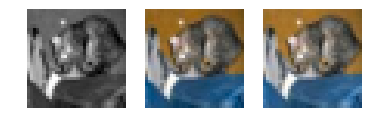

<Figure size 432x288 with 0 Axes>

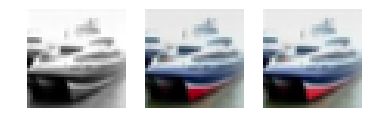

<Figure size 432x288 with 0 Axes>

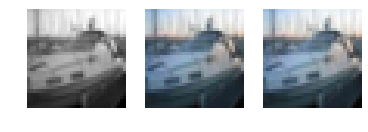

<Figure size 432x288 with 0 Axes>

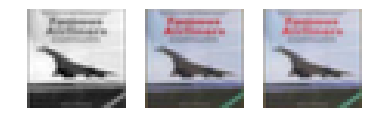

<Figure size 432x288 with 0 Axes>

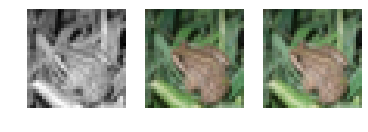

<Figure size 432x288 with 0 Axes>

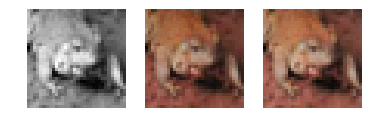

<Figure size 432x288 with 0 Axes>

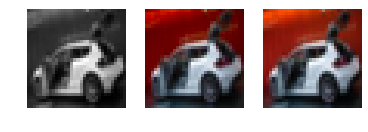

<Figure size 432x288 with 0 Axes>

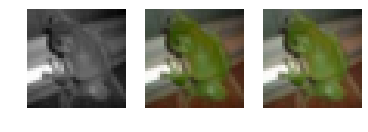

<Figure size 432x288 with 0 Axes>

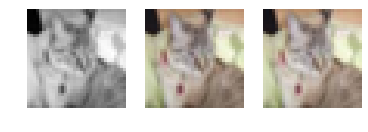

<Figure size 432x288 with 0 Axes>

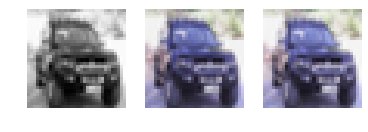

<Figure size 432x288 with 0 Axes>

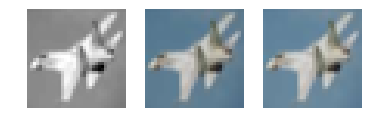

In [6]:
for i, (input_gray, input_ab, colour) in enumerate(val_loader):
    for j in range(1):
        to_rgb(input_gray[j].cpu(), input_ab[j].cpu(), colour[j].cpu())
    if i == 10: break